In [231]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import os
from prophet import Prophet
import json
from datetime import datetime

In [34]:
from http.cookiejar import CookieJar

In [3]:
links = ["https://web.archive.org/web/20190524171902/https://socialblade.com/youtube/user/mmoshaya/monthly",
        "https://web.archive.org/web/20190524075036/https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
         "https://web.archive.org/web/20190830014628/https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
        "https://web.archive.org/web/20190524134324/https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
        "https://web.archive.org/web/20190525094206/https://socialblade.com/youtube/user/banderitax/monthly",
        "https://web.archive.org/web/20190830022605/https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [4]:
# save req to html file if not found
for i in range(len(links)):
    if f"req{i}.html" not in os.listdir('.'):
        open("req"+str(i)+".html","w",encoding="UTF-8").write(requests.get(links[i]).text)

In [5]:
# read files from  disk - files name: req0.html .... req4.html
resText = [open("req"+str(i)+".html","r",encoding="UTF-8").read() for i in range(len(links))]

In [6]:
def getChartData(soup,chart_name):
    ds_element = soup.find("div",{"id":chart_name}).next_element.next_element.text
    regex = "[0-9]+-[0-9]+-[0-9]+,[0-9]+"
    dailySub = [i.split(",") for i in re.findall(regex,ds_element)]
    Date = pd.Series([i[0] for i in dailySub])
    count = pd.Series([i[1] for i in dailySub])
    return pd.DataFrame({"Date":Date.astype(np.datetime64),
                         chart_name:count.astype(np.int64)
                        })

In [7]:
def getDailySubscribers(soup):
    '''
    return dataframe contains date and dailySubscribers for the given soup
    '''
    return getChartData(soup,"DailySubscribers")

In [8]:
def getTotalSubscribers(soup):
    '''
    return dataframe contains date and totalSubscribers for the given soup
    '''
    return getChartData(soup,"TotalSubscribers")

In [9]:
def getDailyVideoViews(soup):
    '''
    return dataframe contains date and dailyVideoViews for the given soup
    '''
    return getChartData(soup,"DailyVideoViews")

In [10]:
def getTotalVideoViews(soup):
    '''
    return dataframe contains date and totalVideoViews for the given soup
    '''
    return getChartData(soup,"TotalVideoViews")

In [11]:
def getAllCharts(soup):
    '''
    return dataframe contains date, dailySubscribers, totalSubscribers, dailyVideoViews and totalVideoViews for the given soup
    '''
    ds = getDailySubscribers(soup)
    ts = getTotalSubscribers(soup)
    dv = getDailyVideoViews(soup)
    tv = getTotalVideoViews(soup)
    return ds.merge(ts,on="Date").merge(dv,on="Date").merge(tv,on="Date")

In [12]:
soups = [BeautifulSoup(r,"html5lib") for r in resText]

In [13]:
channels_df = [getAllCharts(soup) for soup in soups]

In [31]:
top1_df = channels_df[0] # top 1 channel df
top2_df = channels_df[1] # top 2 channel df
top3_df = channels_df[2] # top 3 channel df
# top4_df = channels_df[3] # top 4 channel df شلناها لان عدد الروز قليل
top4_df = channels_df[4] # top 4 channel df
top5_df = channels_df[5] # top 4 channel df

In [81]:
X_y = top1_df[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
X_y.columns = ["ds","y"]
m = Prophet(daily_seasonality=True)
m.fit(X_y)

In [78]:
future = m.make_future_dataframe(periods=365)

In [79]:
forecast = m.predict(future)

In [80]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1446,2020-05-18,1.795172e+07,1.559225e+07,2.032929e+07
1447,2020-05-19,1.797101e+07,1.560440e+07,2.037586e+07
1448,2020-05-20,1.799028e+07,1.561759e+07,2.038922e+07
1449,2020-05-21,1.800945e+07,1.562586e+07,2.043065e+07
1450,2020-05-22,1.802911e+07,1.563361e+07,2.047970e+07


In [72]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1384,2020-05-18,1.757732e+07,1.539438e+07,2.013917e+07
1385,2020-05-19,1.759544e+07,1.539522e+07,2.017093e+07
1386,2020-05-20,1.761342e+07,1.541655e+07,2.019766e+07
1387,2020-05-21,1.763163e+07,1.541582e+07,2.023732e+07
1388,2020-05-22,1.764948e+07,1.542358e+07,2.026950e+07


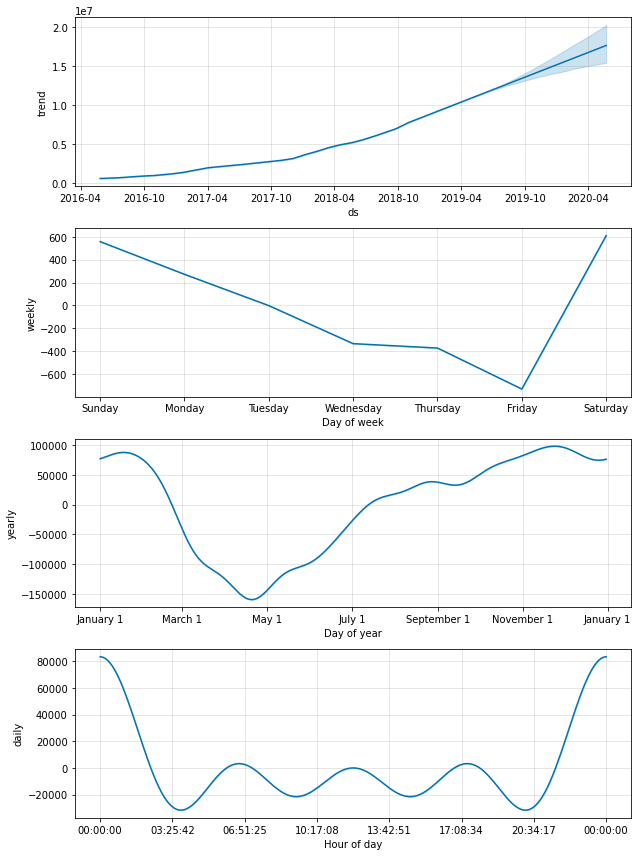

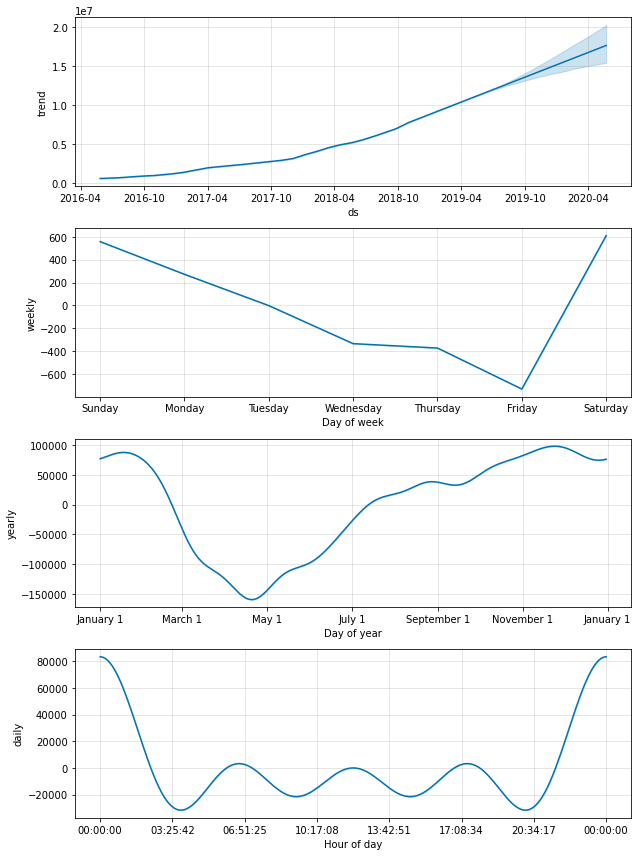

In [70]:
 m.plot_components(forecast)

In [14]:
# total number of rows
total = 0
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    total += len(c)
print(f"the total number of rows is {total}")

the total number of rows is 5314


In [15]:
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    print(c.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086 entries, 0 to 1085
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              1086 non-null   object
 1   DailySubscribers  1086 non-null   object
 2   TotalSubscribers  1086 non-null   object
 3   DailyVideoViews   1086 non-null   object
 4   TotalVideoViews   1086 non-null   object
dtypes: object(5)
memory usage: 50.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086 entries, 0 to 1085
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              1086 non-null   object
 1   DailySubscribers  1086 non-null   object
 2   TotalSubscribers  1086 non-null   object
 3   DailyVideoViews   1086 non-null   object
 4   TotalVideoViews   1086 non-null   object
dtypes: object(5)
memory usage: 50.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10

In [186]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
r = str(opener.open("https://socialblade.com/youtube/user/mmoshaya/monthly").read())

In [194]:
lists = [json.loads(l[0]) for l in re.findall('(\[(\[\d+,\d+\],?)+\])',r)]

In [188]:
col = re.findall('title: { text: \\\\\'([\w|\s]+) for',r)

In [275]:
col

['Weekly Subscribers Gained',
 'Weekly Video Views Gained',
 'Total Subscribers',
 'Total Video Views',
 'Total Subscribers',
 'Total Video Views']

In [276]:
date1 = pd.Series([i[0] for i in lists[0]])
df1 = pd.DataFrame({
    "Date": pd.to_datetime(date1,unit="ms").dt.date, #parse Date from timestamp to date
    col[0]: [i[1] for i in lists[0]],
    col[1]: [i[1] for i in lists[1]],
})

date2 = pd.Series([i[0] for i in lists[2]])
df2 = pd.DataFrame({
    "Date": pd.to_datetime(date2,unit="ms").dt.date, #parse Date from timestamp to date
    col[2]: [i[1] for i in lists[2]],
    col[3]: [i[1] for i in lists[3]],
})

date3 = pd.Series([i[0] for i in lists[4]])
df3 = pd.DataFrame({
    "Date": pd.to_datetime(date3,unit="ms").dt.date, #parse Date from timestamp to date
    col[4]: [i[1] for i in lists[4]],
    col[5]: [i[1] for i in lists[5]],
})

In [280]:
df2

,Date,Total Subscribers,Total Video Views
0,2021-08-01,20600000,14147979000
1,2021-07-01,20400000,13859725817
2,2021-06-01,20200000,13568471366
3,2021-05-01,20000000,13282117001
4,2021-04-01,19700000,12917933624
5,2021-03-01,19300000,12578733516
6,2021-02-01,19100000,12296234347
7,2021-01-01,18900000,12007468966
8,2020-12-01,18700000,11723144157
9,2020-11-01,18400000,11424122268


In [252]:
df.Date.apply(lambda d: datetime.fromtimestamp(d/1000))

0     2018-09-21 07:00:00
1     2018-09-24 07:00:00
2     2018-10-01 07:00:00
3     2018-10-08 07:00:00
4     2018-10-15 07:00:00
              ...        
151   2021-08-09 07:00:00
152   2021-08-16 07:00:00
153   2021-08-23 07:00:00
154   2021-08-30 07:00:00
155   2021-09-06 07:00:00
Name: Date, Length: 156, dtype: datetime64[ns]

datetime.datetime(2018, 9, 21, 7, 0)

# needs to check it 


In [ ]:
with open('req0.html') as page:
    html = page.read()
soup = BeautifulSoup(html, 'lxml')

In [ ]:
#print(soup.prettify())

In [ ]:
# up_string = soup.find_all(text=re.compile('Up'))
# up_string

In [ ]:
# rows = [row for row in soup.find_all("span",class_="YouTubeUserTopLight")]
# rows

In [ ]:
# soup.find_all("span",class_="YouTubeUserTopLight")[0].text

In [ ]:
# rows = [row for row in soup.find_all("span",style="font-weight: bold;")] 
# rows[0:6]

In [ ]:
list_columns=[]
for i in soup.find_all("span",class_="YouTubeUserTopLight"):
        list_columns.append(i.get_text())
print(list_columns)

In [ ]:
list_req0=[]
for i in soup.find_all("span",style="font-weight: bold;"):
        list_req0.append(i.get_text())
print(list_req0)